---
title: "Predicting house prices: a regression example"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 3, Section 7 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

In our two previous examples, we were considering classification problems, where the goal was to predict a single discrete label of an input data point. Another common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.

Do not mix up "regression" with the algorithm "logistic regression": confusingly, "logistic regression" is not a regression algorithm, it is a classification algorithm.

## The Boston Housing Price dataset


We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100...

Let's take a look at the data:

In [0]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’




Note: "%<-%" in the next cell is a parallel assignment operator introduced by package zeallot, which is included in package keras. 

In [0]:
library(keras)

dataset <- dataset_boston_housing()
c(c(train_data, train_targets), c(test_data, test_targets)) %<-% dataset

In [0]:
str(train_data)

 num [1:404, 1:13] 1.2325 0.0218 4.8982 0.0396 3.6931 ...


In [0]:
str(test_data)

 num [1:102, 1:13] 18.0846 0.1233 0.055 1.2735 0.0715 ...


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as 
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [0]:
str(train_targets)

 num [1:404(1d)] 15.2 42.3 50 21.1 17.7 18.5 11.3 15.6 15.6 14.4 ...


The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not inflation-adjusted.

## Preparing the data


It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in R using the `scale()` function.

In [0]:
mean <- apply(train_data, 2, mean)
std <- apply(train_data, 2, sd)
train_data <- scale(train_data, center = mean, scale = std)
test_data <- scale(test_data, center = mean, scale = std)

Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building our network

Because so few samples are available, we will be using a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [0]:
# Because we will need to instantiate the same model multiple times,
# we use a function to construct it.
build_model <- function() {
  model <- keras_model_sequential() %>% 
    layer_dense(units = 64, activation = "relu", 
                input_shape = dim(train_data)[[2]]) %>% 
    layer_dense(units = 64, activation = "relu") %>% 
    layer_dense(units = 1) 
    
  model %>% compile(
    optimizer = "rmsprop", 
    loss = "mse", 
    metrics = c("mae")
  )
}

Our network ends with a single unit, and no activation (i.e. it will be linear layer). This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). Applying an activation function would constrain the range that the output can take; for instance if we applied a `sigmoid` activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average.

## Validating our approach using K-fold validation

To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

In terms of code, this is straightforward:

In [0]:
k <- 4
indices <- sample(1:nrow(train_data))
folds <- cut(1:length(indices), breaks = k, labels = FALSE) 

num_epochs <- 100
all_scores <- c()
for (i in 1:k) {
  cat("processing fold #", i, "\n")
  # Prepare the validation data: data from partition # k
  val_indices <- which(folds == i, arr.ind = TRUE) 
  val_data <- train_data[val_indices,]
  val_targets <- train_targets[val_indices]
  
  # Prepare the training data: data from all other partitions
  partial_train_data <- train_data[-val_indices,]
  partial_train_targets <- train_targets[-val_indices]
  
  # Build the Keras model (already compiled)
  model <- build_model()
  
  # Train the model (in silent mode, verbose=0)
  model %>% fit(partial_train_data, partial_train_targets,
                epochs = num_epochs, batch_size = 1, verbose = 0)
                
  # Evaluate the model on the validation data
  results <- model %>% evaluate(val_data, val_targets, verbose = 0)
  all_scores <- c(all_scores, results$mean_absolute_error)
}  

processing fold # 1 
processing fold # 2 
processing fold # 3 
processing fold # 4 


In [0]:
all_scores

[1] 2.382801 2.354027 2.489501 2.533366

In [0]:
mean(all_scores)

[1] 2.439924

As you can notice, the different runs do indeed show rather different validation scores, from 2.1 to 2.6. Their average (2.37) is a much more reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by \$2,375 on average, which is still significant considering that the prices range from \$10,000 to \$50,000. 

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [0]:
# Some memory clean-up
k_clear_session()

In [0]:
num_epochs <- 500
all_mae_histories <- NULL
for (i in 1:k) {
  cat("processing fold #", i, "\n")
  
  # Prepare the validation data: data from partition # k
  val_indices <- which(folds == i, arr.ind = TRUE)
  val_data <- train_data[val_indices,]
  val_targets <- train_targets[val_indices]
  
  # Prepare the training data: data from all other partitions
  partial_train_data <- train_data[-val_indices,]
  partial_train_targets <- train_targets[-val_indices]
  
  # Build the Keras model (already compiled)
  model <- build_model()
  
  # Train the model (in silent mode, verbose=0)
  history <- model %>% fit(
    partial_train_data, partial_train_targets,
    validation_data = list(val_data, val_targets),
    epochs = num_epochs, batch_size = 1, verbose = 0
  )
  mae_history <- history$metrics$val_mean_absolute_error
  all_mae_histories <- rbind(all_mae_histories, mae_history)
}

processing fold # 1 
processing fold # 2 
processing fold # 3 
processing fold # 4 


We can then compute the average of the per-epoch MAE scores for all folds:

In [0]:
average_mae_history <- data.frame(
  epoch = seq(1:ncol(all_mae_histories)),
  validation_mae = apply(all_mae_histories, 2, mean)
)

Let's plot this:

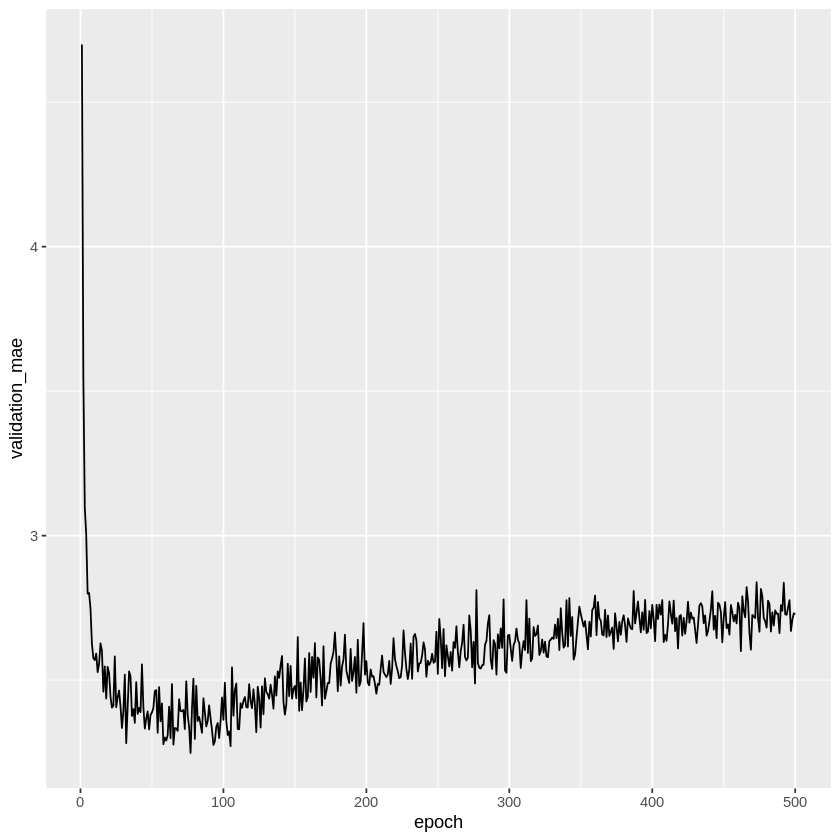

In [0]:
library(ggplot2)
ggplot(average_mae_history, aes(x = epoch, y = validation_mae)) + geom_line()

It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's use `geom_smooth()` to try to get a clearer picture:

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



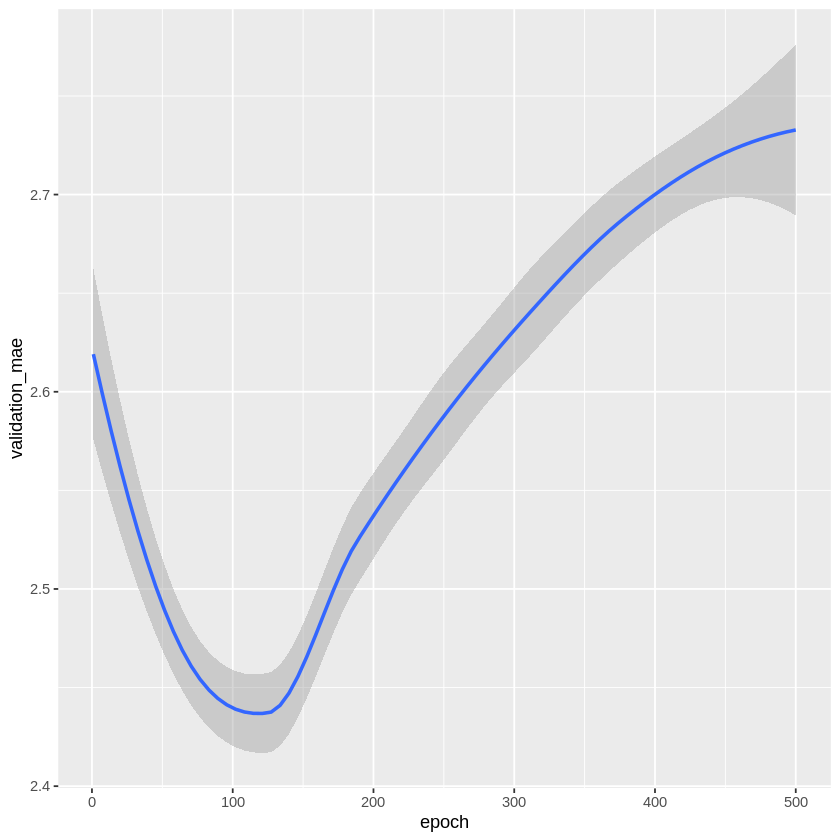

In [0]:
ggplot(average_mae_history, aes(x = epoch, y = validation_mae)) + geom_smooth()

According to this plot, it seems that validation MAE stops improving significantly after 70 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [0]:
# Get a fresh, compiled model.
model <- build_model()

# Train it on the entirety of the data.
model %>% fit(train_data, train_targets,
          epochs = 80, batch_size = 16, verbose = 0)

result <- model %>% evaluate(test_data, test_targets)

In [0]:
result

$loss
[1] 18.07716

$mean_absolute_error
[1] 2.610508

We are still off by about \$2,680.

## Wrapping up


Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.

This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.

In the next chapter, you will acquire a more formal understanding of some of the concepts you have encountered in these first examples, such as data preprocessing, model evaluation, and overfitting.